In [1]:
model_comparison = dict()

In [2]:
from utils.supports import *
import scipy.stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
# import seaborn aspi sns
# sns.set(style='white', rc={'image.cmap': 'Blues'})

import numpy as np
from tqdm import tqdm
from scipy.stats import bernoulli,norm,uniform

import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Tensorflow reimplementation to support auto-differentiation
tf.reset_default_graph()
class Generator():
    def __init__(self, dimension, pot_id):
        self.dim = dimension
        self.pot_id = pot_id
        self.build_graph()
    
    @staticmethod
    def norm_square(tensor, mean, var):
        return 0.5*tf.square((tensor - mean)/var)
    
    @staticmethod
    def w1(tensor):
        return tf.sin(2*np.pi*tensor[:,0]/4)
    
    def w2(self, tensor):
        return 3*tf.exp(-self.norm_square(tensor[:,0],1,0.6))
    
    @staticmethod
    def w3(tensor):
        return 3*tf.nn.sigmoid((tensor[:,0]-1)/0.3)

    
    def build_graph(self):
        self.obs = tf.placeholder(tf.float32, shape=[None, self.dim], name='q')
        #p(x)
        with tf.variable_scope('log_like'):
            if self.pot_id == 0:
                self.log_probs = self.norm_square(tf.norm(self.obs, ord=2, axis=1), 2, 0.4)\
                                 - tf.log(tf.exp(-self.norm_square(self.obs[:,0], 2, 0.6)) 
                                          + tf.exp(-self.norm_square(self.obs[:,0], -2, 0.6)))
                    
            if self.pot_id == 1:
                self.log_probs = self.norm_square(self.obs[:,1], self.w1(self.obs), 0.4)   
                
            
            if self.pot_id == 2:
                self.log_probs = -tf.log(tf.exp(-self.norm_square(self.obs[:,1], self.w1(self.obs), 0.35))
                                        +tf.exp(-self.norm_square(self.obs[:,1], 
                                                                  self.w1(self.obs)-self.w2(self.obs), 
                                                                  0.35))
                                        )
                
            if self.pot_id == 3:
                self.log_probs = -tf.log(tf.exp(-self.norm_square(self.obs[:,1], self.w1(self.obs), 0.35))
                                        +tf.exp(-self.norm_square(self.obs[:,1], 
                                                                  self.w1(self.obs)-self.w3(self.obs), 
                                                                  0.35))
                                        )
            
            
            self.probs = tf.exp(-self.log_probs)
        with tf.variable_scope('gradient'):
            self.gradient = tf.gradients(tf.reduce_sum(self.log_probs), self.obs)
            
        self._sesh = tf.Session()
        
    def get_density(self, observation):
        density = self._sesh.run(self.probs,
                                 feed_dict={self.obs: observation})
        return density
        
    def get_log_density(self, observation):
        log_like = self._sesh.run(self.log_probs,
                                  feed_dict={self.obs: observation})
        return log_like
    
    def get_gradient(self, observation):
        gradient = self._sesh.run(self.gradient, 
                                  feed_dict={self.obs: observation})
        return gradient[0]

In [4]:
g = []
for i in range(4):
    g.append(Generator(2,i))

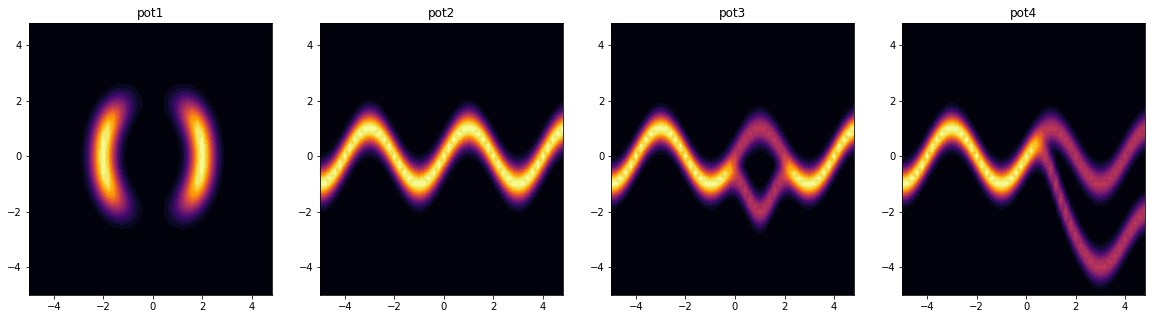

In [5]:
# make a plot of the target density
plt.clf()
fig,ax = plt.subplots(1, 4, figsize=(20, 5))
xs = arange(-5,5,.2)
x1,x2 = meshgrid(xs,xs)
obs = []
for i in range(x1.shape[0]):
    for j in range(x1.shape[1]):
        obs.append([x1[i,j],x2[i,j]]) 
for i in range(len(g)):        
        P = g[i].get_density(obs)
        cmap = plt.get_cmap('inferno')
        P = P.reshape(len(xs),len(xs))
        ax[i].contourf(x1,x2,P,30, cmap=cmap)
        ax[i].set_title("pot{0}".format(i+1))

In [6]:
class RejectionSampling(object):
    def __init__(self, generator, batch_size, latent_dim):
        self.generator = generator
        self.dim = latent_dim
        self.batch_size = batch_size
        self.M = 1
    
        
        
    def sampler(self):
        x = np.random.uniform(-5, 5, size=[self.batch_size, self.dim])
        px = self.generator.get_density(x)
        qx = 1
        
        self.M = max(px/qx)
        
        rate = np.random.random_sample(size=self.batch_size)
        cond = rate < px/(qx*self.M)
        accepted_x = np.array([xv for (c,xv) in zip(cond,x) if c])
        
        return accepted_x, cond
    
    def gather_samples(self, size=1):
        precentages = []
        samples = []
        
        for i in tqdm(range(size)):
            q, precentage = self.sampler()
            samples.append(q)
            precentages.append(precentage)

        return np.vstack(samples), np.average(precentages)

In [7]:
r = []
for i in range(4):
    r.append(RejectionSampling(g[i], 50000, 2))

In [8]:
P_list = []
rs_list = []

100%|██████████| 1/1 [00:00<00:00, 32.36it/s]


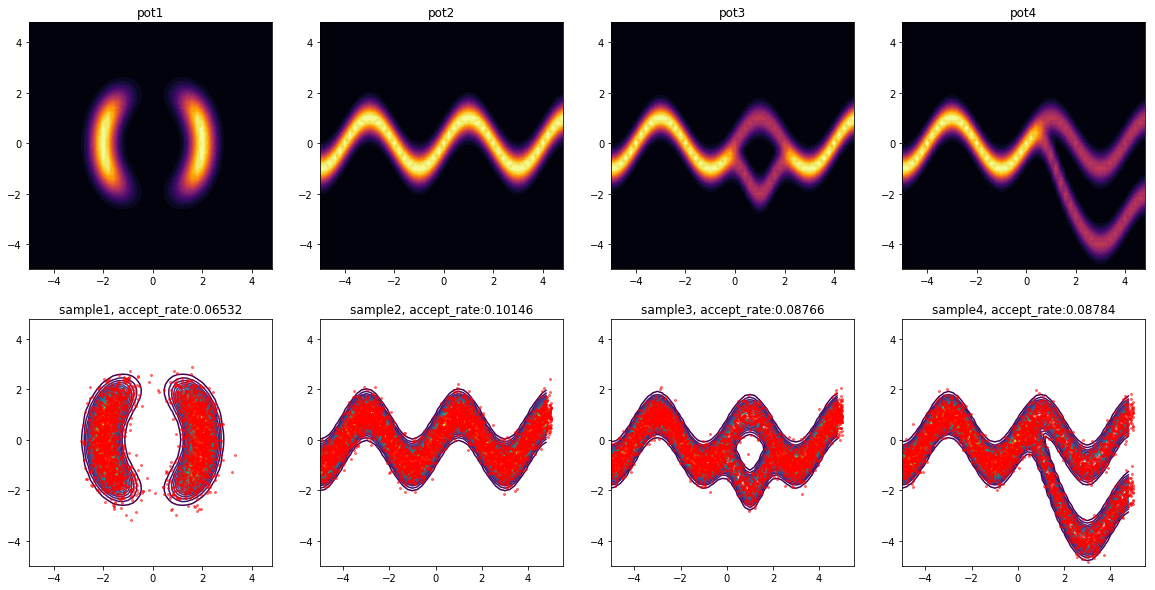

In [9]:
# make a plot of the target density
plt.clf()
fig,ax = plt.subplots(2, 4, figsize=(20, 10))
xs = arange(-5,5,.2)
x1,x2 = meshgrid(xs,xs)
obs = []
for i in range(x1.shape[0]):
    for j in range(x1.shape[1]):
        obs.append([x1[i,j],x2[i,j]]) 
for i in range(len(g)):        
        P = g[i].get_density(obs)
        cmap = plt.get_cmap('inferno')
        P = P.reshape(len(xs),len(xs))
        P_list.append(P)
        ax[0,i].contourf(x1,x2,P,30, cmap=cmap)
        ax[0,i].set_title("pot{0}".format(i+1))
        ax[1,i].contour(x1,x2,P,30)
        rs_samples, accept_rate = r[i].gather_samples()
        rs_list.append(rs_samples)
        ax[1,i].plot(rs_samples[:,0],rs_samples[:,1],'ro',markersize=2, alpha=.5)
        ax[1,i].set_title("sample{0}, accept_rate:{1}".format(i+1, accept_rate))

In [10]:
from tensorflow.contrib import layers
from utils.planar import Planar
from utils.activations import lrelu,leaky_rectify
from utils.jacobian import get_determinant, get_jacobian
from utils.codings import planar_projector, fc_noise_projector
from tensorflow.contrib.framework import arg_scope

from collections import defaultdict

In [11]:
class DeepVariationalInference(object):

    def __init__(self, latent_dim, pot_id,
                 num_layer,
                 optimizer=tf.train.AdamOptimizer,
                 learning_rate=1e-3,
                 activation=tf.tanh
                 ):
        """
        """
        self.latent_dim = latent_dim
        self.pot_id = pot_id
        self.num_layer = num_layer
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.activation = activation
        self.build_graph()
        self._sesh = tf.Session()
        init = tf.global_variables_initializer()
        self._sesh.run(init)
        self.history = {'kl':[], 'sample':[]}
    
    @staticmethod
    def norm_square(tensor, mean, var):
        return 0.5*tf.square((tensor - mean)/var)
    
    @staticmethod
    def w1(tensor):
        return tf.sin(2*np.pi*tensor[:,0]/4)
    
    def w2(self, tensor):
        return 3*tf.exp(-self.norm_square(tensor[:,0],1,0.6))
    
    @staticmethod
    def w3(tensor):
        return 3*tf.nn.sigmoid((tensor[:,0]-1)/0.3)

    def get_name(self):
        pass

    def build_graph(self):
        pass

    def update(self, noise, partialx, mask):
        pass
    
        
    def get_history(self):
        return self.history
    
    def clean_history(self):
        self.history = defaultdict()

In [20]:
class NormalizingFlowVIN(DeepVariationalInference):    
    def get_name(self):
        return "NF"
    
    def build_graph(self):
        
        with tf.variable_scope('dvi') as env:
            self.noise = tf.placeholder(tf.float32, shape=[None, self.latent_dim])
            with tf.variable_scope('projector'):
                self.obs, self.logdet = planar_projector(self.noise, self.num_layer, self.latent_dim)
            
            trainable_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, env.name+"/projector")
            
            with tf.variable_scope('log_like'):
                if self.pot_id == 0:
                    self.log_probs = self.norm_square(tf.norm(self.obs, ord=2, axis=1), 2, 0.4)\
                                     - tf.log(tf.exp(-self.norm_square(self.obs[:,0], 2, 0.6)) 
                                              + tf.exp(-self.norm_square(self.obs[:,0], -2, 0.6)))

                if self.pot_id == 1:
                    self.log_probs = self.norm_square(self.obs[:,1], self.w1(self.obs), 0.4)   


                if self.pot_id == 2:
                    self.log_probs = -tf.log(tf.exp(-self.norm_square(self.obs[:,1], self.w1(self.obs), 0.35))
                                            +tf.exp(-self.norm_square(self.obs[:,1], 
                                                                      self.w1(self.obs)-self.w2(self.obs), 
                                                                      0.35))
                                            )

                if self.pot_id == 3:
                    self.log_probs = -tf.log(tf.exp(-self.norm_square(self.obs[:,1], self.w1(self.obs), 0.35))
                                            +tf.exp(-self.norm_square(self.obs[:,1], 
                                                                      self.w1(self.obs)-self.w3(self.obs), 
                                                                      0.35))
                                            )


                self.probs = tf.exp(-self.log_probs)
                self.loglike = self.log_probs
            with tf.variable_scope('loss'):
                self.loss = tf.reduce_sum(self.logdet + self.loglike)
                
                with tf.variable_scope('optimizer'):
                    optimizer = self.optimizer(learning_rate=self.learning_rate) 
#                     self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss=self.loss, 
#                                                                             method='L-BFGS-B', 
#                                                                             var_list=trainable_variables,
#                                                                             options={'maxiter': 100})
                    
            with tf.variable_scope('training-step'):
                self.train = optimizer.minimize(loss=self.loss, var_list=trainable_variables)
      
    def call_back(self, loss, obs):
        self.history['kl'].append(loss)
        self.history['sample'].append(obs)
    
    def update(self, noise, iteration=10000, random_noise=False):
#         self.optimizer.minimize(session=self._sesh, 
#                                 feed_dict={self.noise:noise},
#                                 loss_callback=self.call_back,
#                                 fetches=[self.loss, self.obs]
#                                )
        noise_shape = noise.shape
        previous_loss = None
        tbar = tqdm(range(iteration))
        for i in tbar:
            if random_noise:
                noise = np.random.normal(size=noise_shape)
            _, loss, sample = self._sesh.run([self.train, self.loss, self.obs],
                                             feed_dict={self.noise: noise}
                                             )
            self.call_back(loss, sample)

            s = "Loss: {:.4f}".format(loss)
            tbar.set_description(s)

            previous_loss = loss
    
    def sampler(self, noise):
        sample = self._sesh.run(self.obs, feed_dict={self.noise:noise})
        return sample

Loss: -18.0907: 100%|██████████| 10000/10000 [04:32<00:00, 36.71it/s]


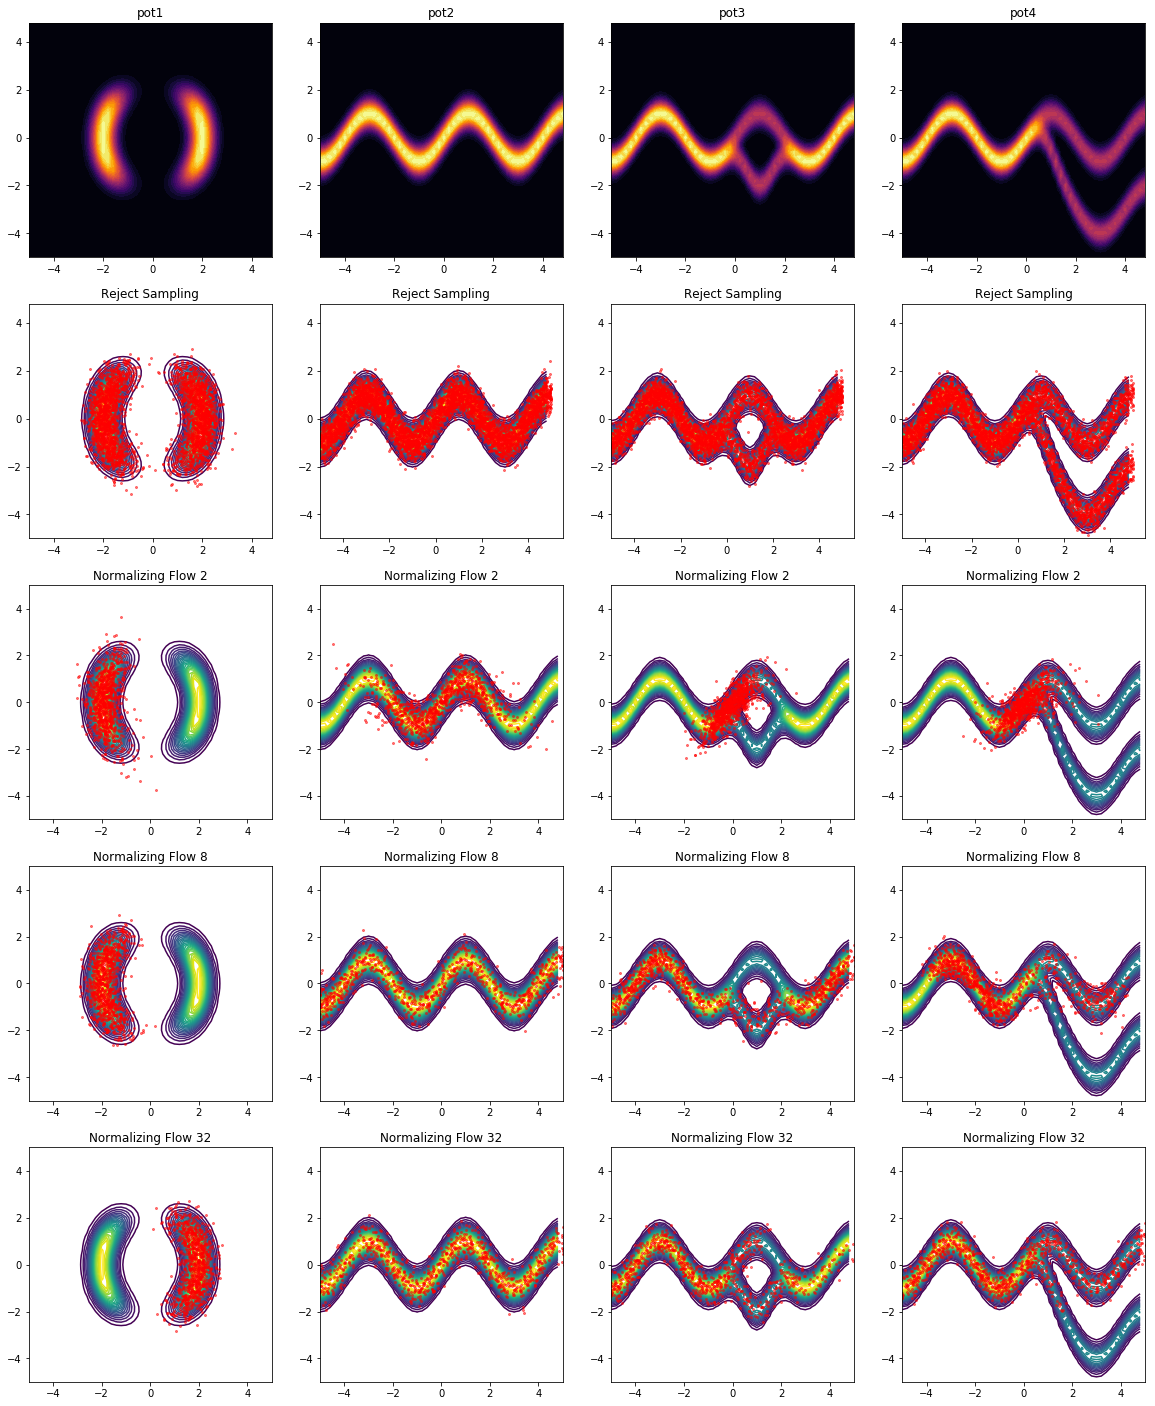

In [13]:
# make a plot of the target density
noise = np.random.normal(size=[1000, 2])
plt.clf()
fig,ax = plt.subplots(5, 4, figsize=(20, 25))
xs = arange(-5,5,.2)
x1,x2 = meshgrid(xs,xs)

for i in range(len(g)):        
        cmap = plt.get_cmap('inferno')
        ax[0,i].contourf(x1,x2,P_list[i],30, cmap=cmap)
        ax[0,i].set_title("pot{0}".format(i+1))
        ax[1,i].contour(x1,x2,P_list[i],30)
        ax[1,i].plot(rs_list[i][:,0],rs_list[i][:,1],'ro',markersize=2, alpha=.5)
        ax[1,i].set_title("Reject Sampling")
        tf.reset_default_graph()
        nf = NormalizingFlowVIN(2,i,2)
        nf.update(noise)
        zs = nf.sampler(noise)
        ax[2,i].contour(x1,x2,P_list[i],30)
        ax[2,i].plot(zs[:,0],zs[:,1],'ro',markersize=2, alpha=.5)
        ax[2,i].set_xlim((-5, 5))
        ax[2,i].set_ylim((-5, 5))
        ax[2,i].set_title("Normalizing Flow {0}".format(2))
        
        tf.reset_default_graph()
        nf = NormalizingFlowVIN(2,i,8)
        nf.update(noise)
        zs = nf.sampler(noise)
        ax[3,i].contour(x1,x2,P_list[i],30)
        ax[3,i].plot(zs[:,0],zs[:,1],'ro',markersize=2, alpha=.5)
        ax[3,i].set_xlim((-5, 5))
        ax[3,i].set_ylim((-5, 5))
        ax[3,i].set_title("Normalizing Flow {0}".format(8))
        
        tf.reset_default_graph()
        nf = NormalizingFlowVIN(2,i,32)
        nf.update(noise)
        zs = nf.sampler(noise)
        ax[4,i].contour(x1,x2,P_list[i],30)
        ax[4,i].plot(zs[:,0],zs[:,1],'ro',markersize=2, alpha=.5)
        ax[4,i].set_xlim((-5, 5))
        ax[4,i].set_ylim((-5, 5))
        ax[4,i].set_title("Normalizing Flow {0}".format(32))
        
plt.show()

Loss: 118.9490: 100%|██████████| 10000/10000 [04:47<00:00, 34.73it/s] 


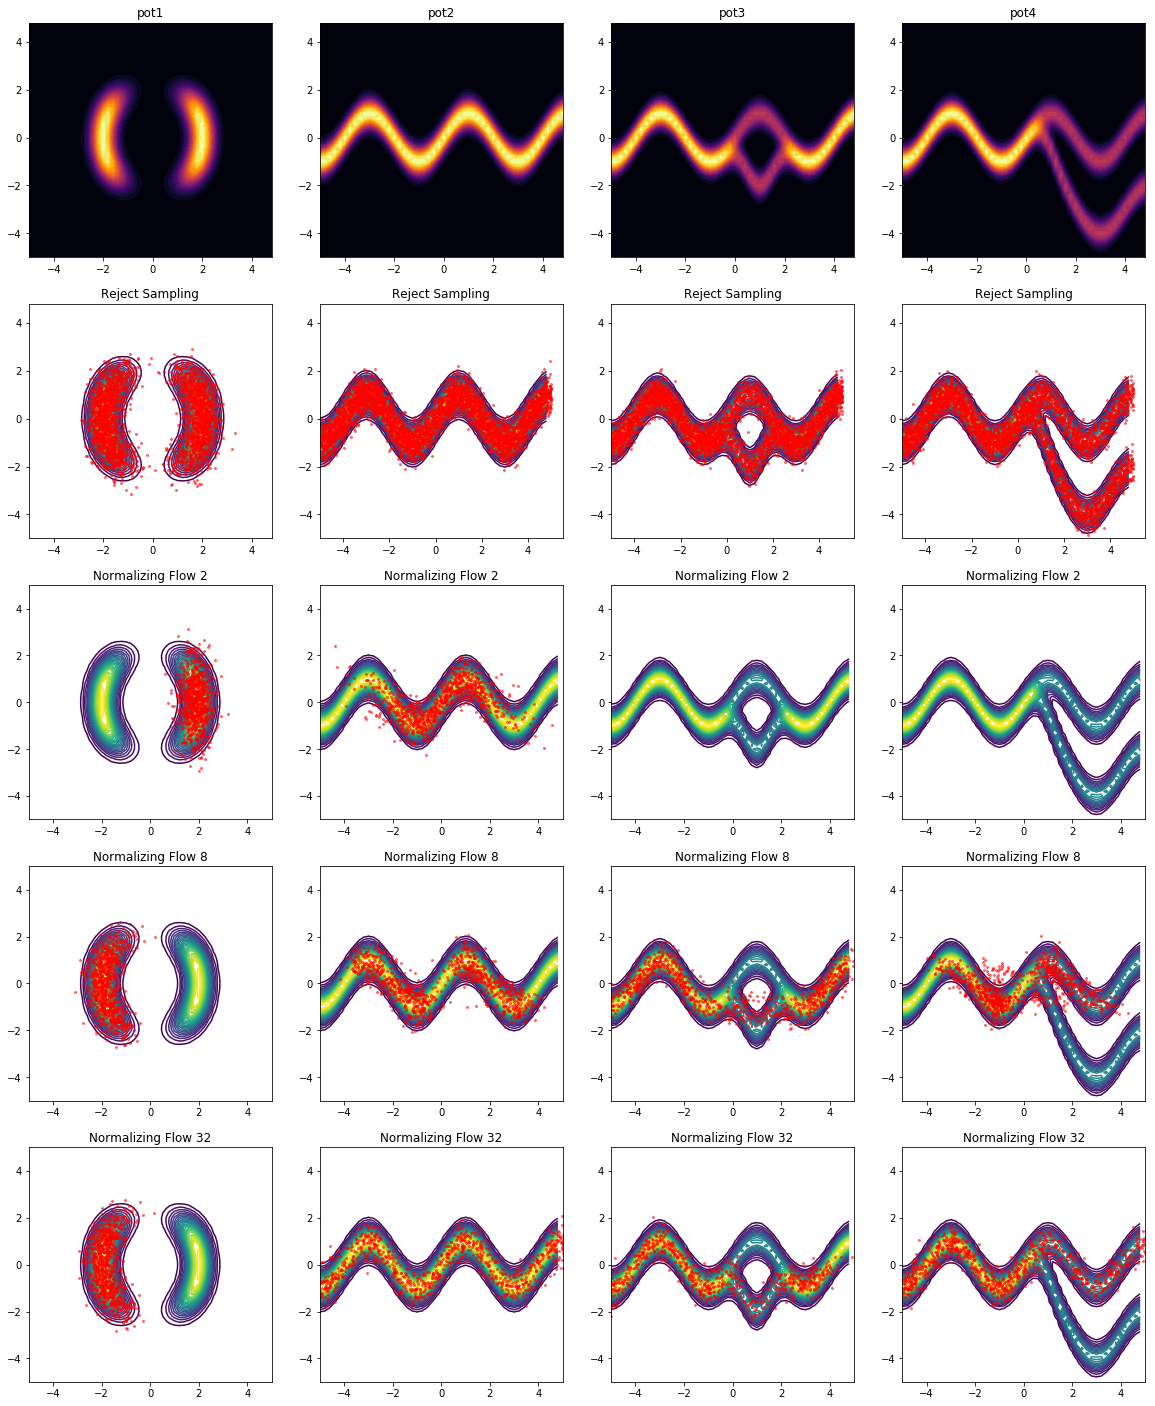

In [22]:
# make a plot of the target density
plt.clf()
fig,ax = plt.subplots(5, 4, figsize=(20, 25))
xs = arange(-5,5,.2)
x1,x2 = meshgrid(xs,xs)

for i in range(len(g)):        
        cmap = plt.get_cmap('inferno')
        ax[0,i].contourf(x1,x2,P_list[i],30, cmap=cmap)
        ax[0,i].set_title("pot{0}".format(i+1))
        ax[1,i].contour(x1,x2,P_list[i],30)
        ax[1,i].plot(rs_list[i][:,0],rs_list[i][:,1],'ro',markersize=2, alpha=.5)
        ax[1,i].set_title("Reject Sampling")
        tf.reset_default_graph()
        nf = NormalizingFlowVIN(2,i,2)
        nf.update(noise, random_noise=True)
        zs = nf.sampler(noise)
        ax[2,i].contour(x1,x2,P_list[i],30)
        ax[2,i].plot(zs[:,0],zs[:,1],'ro',markersize=2, alpha=.5)
        ax[2,i].set_xlim((-5, 5))
        ax[2,i].set_ylim((-5, 5))
        ax[2,i].set_title("Normalizing Flow {0}".format(2))
        
        tf.reset_default_graph()
        nf = NormalizingFlowVIN(2,i,8)
        nf.update(noise, random_noise=True)
        zs = nf.sampler(noise)
        ax[3,i].contour(x1,x2,P_list[i],30)
        ax[3,i].plot(zs[:,0],zs[:,1],'ro',markersize=2, alpha=.5)
        ax[3,i].set_xlim((-5, 5))
        ax[3,i].set_ylim((-5, 5))
        ax[3,i].set_title("Normalizing Flow {0}".format(8))
        
        tf.reset_default_graph()
        nf = NormalizingFlowVIN(2,i,32)
        nf.update(noise, random_noise=True)
        zs = nf.sampler(noise)
        ax[4,i].contour(x1,x2,P_list[i],30)
        ax[4,i].plot(zs[:,0],zs[:,1],'ro',markersize=2, alpha=.5)
        ax[4,i].set_xlim((-5, 5))
        ax[4,i].set_ylim((-5, 5))
        ax[4,i].set_title("Normalizing Flow {0}".format(32))
        
plt.show()

# Discussion
## observation:
1. It is rare to see that normalizing flow can capture multi-mode.
2. Wasn't able to reproduce the paper result as they show on the paper. Indicating limited flexibility of Planar.

## other:
1. The trick is constructing inversible matrix described in Appendix of the paper, not the function given in the main content.
2. Didn't see any other implementation of normalizing flow other than Planar and IAF(while we could not use IAF)

3. Same observation mentioned on [Github](https://github.com/casperkaae/parmesan/issues/22). It seems like they had same issue that I encoutered. The solution they came out is to increase the initialization variance for w and u.


In [14]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [15]:
show_graph(tf.get_default_graph().as_graph_def())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


# Check if the close form log-determinant is equal to auto-differentiation results

In [16]:
import tensorflow as tf
from utils.jacobian import get_determinant, get_jacobian

class Planarx(object):
    """Planar Normalization Flow"""

    def __init__(self, scope="planar", activation=tf.identity):
        self.scope = scope
        self.activation = activation

    def __call__(self, input):
        with tf.name_scope(self.scope):
            self.output_dim = input.get_shape()[1].value
            while True:
                try:
                    z = input
                    uw = tf.matmul(tf.transpose(self.u), self.w)
                    muw = -1 + tf.log(1 + tf.exp(uw))
                    u_hat = self.u + tf.matmul(self.w / tf.reduce_sum(self.w ** 2), (muw - uw))
                    zwb = tf.matmul(z, self.w) + self.b
                    f_z = z + tf.matmul(tf.nn.tanh(zwb), tf.transpose(u_hat))

                    psi = tf.matmul(1 - tf.nn.tanh(zwb) ** 2, tf.transpose(self.w))
                    psi_u = tf.matmul(psi, u_hat)
                    logdet_2 = tf.reshape(-tf.log(tf.abs(1 + psi_u)), [-1])

                    determinant = get_determinant(get_jacobian(f_z, z))
                    logdet_1 = -tf.log(determinant)

                    return f_z, logdet_1, logdet_2

                except Exception:
                    self.w = self.weight_variable([self.output_dim, 1], 'w')
                    self.u = self.weight_variable([self.output_dim, 1], 'u')
                    self.b = self.bias_variable()

    # Weight constructing function
    @staticmethod
    def weight_variable(shape, name="w"):
        initial = tf.truncated_normal(shape, stddev=0.005)
        return tf.Variable(initial, name=name)

    # Bias constructing function
    @staticmethod
    def bias_variable():
        initial = tf.constant(0.)
        return tf.Variable(initial, name="b")

In [17]:
planar = Planarx()
z_placeholder = tf.placeholder(tf.float32, shape=[None, 2])
f_z, logdet_1, logdet_2 = planar(z_placeholder)

In [18]:
sesh = tf.Session()
init = tf.global_variables_initializer()
sesh.run(init)

In [19]:
sesh.run([f_z, logdet_1, logdet_2], feed_dict={z_placeholder: noise})

[array([[ 0.9092, -1.2355],
        [ 1.0025,  0.5131],
        [-0.2567, -0.4044],
        ...,
        [-0.0332, -0.2794],
        [ 1.9839,  0.3659],
        [ 0.5029, -0.0173]], dtype=float32),
 array([0.3665, 0.3664, 0.3665, 0.3665, 0.3665, 0.3665, 0.3665, 0.3665, 0.3665, 0.3665, 0.3665,
        0.3665, 0.3665, 0.3662, 0.3664, 0.3661, 0.3665, 0.3664, 0.3665, 0.3665, 0.3664, 0.3664,
        0.3664, 0.3664, 0.3664, 0.3663, 0.3664, 0.3665, 0.3664, 0.3665, 0.3665, 0.3665, 0.3665,
        0.3665, 0.3664, 0.3664, 0.3664, 0.3665, 0.3665, 0.3663, 0.3665, 0.3665, 0.3665, 0.3665,
        0.3664, 0.3665, 0.3664, 0.3664, 0.3665, 0.3662, 0.3664, 0.3665, 0.3665, 0.3664, 0.3665,
        0.3663, 0.3664, 0.3665, 0.3664, 0.3665, 0.3664, 0.3664, 0.3665, 0.3665, 0.3665, 0.3664,
        0.3664, 0.3665, 0.3663, 0.3665, 0.3665, 0.3664, 0.3665, 0.3664, 0.3665, 0.3665, 0.3665,
        0.3665, 0.3665, 0.3665, 0.3665, 0.3665, 0.3665, 0.3664, 0.3665, 0.3662, 0.3665, 0.3665,
        0.3665, 0.3665, 0.3665, 0.